In [5]:
import pandas as pd

df = pd.read_csv("hf://datasets/Mudasir692/text-to-sql/text_to_sql_dataset.csv")

/home/dan/projects/ba_experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
print(df[:1])

                                           sentence  \
0  What is the name of the player that is pick #69?   

                                                 sql  
0  SELECT player FROM table_name_51 WHERE pick__n...  


In [1]:
import pandas as pd
from huggingface_hub import hf_hub_download
import shutil

# Define the dataset file names
splits = {
    'train': 'synthetic_text_to_sql_train.snappy.parquet',
    'test': 'synthetic_text_to_sql_test.snappy.parquet'
}

# Function to download, cache, and optionally copy each split
def download_and_cache(split_name, filename):
    local_path = hf_hub_download(
        repo_id="gretelai/synthetic_text_to_sql",
        filename=filename,
        repo_type="dataset"
    )
    cached_path = f"./cached_{split_name}.parquet"
    shutil.copy(local_path, cached_path)
    return pd.read_parquet(cached_path)

# Load both splits
df_train = download_and_cache("train", splits["train"])
df_test = download_and_cache("test", splits["test"])


/Users/daniel/projects/text2sql_eval/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(print(df_test["sql_complexity"].unique()))

['basic SQL' 'aggregation' 'single join' 'window functions'
 'multiple_joins' 'subqueries' 'set operations' 'CTEs']
None


In [15]:
print(df["domain"][0])
print(df["domain_description"][0])
print(df["sql_complexity"][0])
print(df["sql_complexity_description"][0])
print(df["sql_task_type"][0])
print(df["sql_task_type_description"][0])
print(df["sql_prompt"][0])
print(df["sql_context"][0])
print(df["sql"][0])
print(df["sql_explanation"][0])

forestry
Comprehensive data on sustainable forest management, timber production, wildlife habitat, and carbon sequestration in forestry.
single join
only one join (specify inner, outer, cross)
analytics and reporting
generating reports, dashboards, and analytical insights
What is the total volume of timber sold by each salesperson, sorted by salesperson?
CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT); INSERT INTO salesperson (salesperson_id, name, region) VALUES (1, 'John Doe', 'North'), (2, 'Jane Smith', 'South'); CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE); INSERT INTO timber_sales (sales_id, salesperson_id, volume, sale_date) VALUES (1, 1, 120, '2021-01-01'), (2, 1, 150, '2021-02-01'), (3, 2, 180, '2021-01-01');
SELECT salesperson_id, name, SUM(volume) as total_volume FROM timber_sales JOIN salesperson ON timber_sales.salesperson_id = salesperson.salesperson_id GROUP BY salesperson_id, name ORDER BY total_volume DE

In [13]:
import pandas as pd

df_train = pd.read_parquet("./synthetic_text_to_sql/cached_train.parquet")
df_test = pd.read_parquet("./synthetic_text_to_sql/cached_test.parquet")


In [20]:
def inspect_df(df):
    print("==== Info ====")
    print(df.info())
    print("\n==== Data Types ====")
    print(df.dtypes)
    print("\n==== Shape ====")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n==== Memory Usage ====")
    print(df.memory_usage(deep=True))
    print("\n==== Null Values ====")
    print(df.isnull().sum())
    print("\n==== Unique Values ====")
    print(df.nunique())
    print("\n==== Describe ====")
    print(df.describe(include='all'))
    print("\n==== Sample Rows ====")
    print(df.head())


In [5]:
import pandas as pd
import time
import json
import os
import re
import sqlparse
import sqlglot
from ollama import Client

# === CONFIGURATION ===
MODEL_NAME = "qwen2.5:latest"  # Replace with your actual model tag
LOG_PATH = "benchmark_results.jsonl"
DATASET_PATH = "./synthetic_text_to_sql/cached_test.parquet"
MAX_EXAMPLES = 5  # adjust as needed

# === HELPER FUNCTIONS ===

def normalize_sql(sql):
    """Normalize SQL for comparison using sqlparse."""
    try:
        formatted = sqlparse.format(sql, keyword_case='upper', reindent=True)
        return re.sub(r'\s+', ' ', formatted).strip().lower()
    except Exception:
        return sql.strip().lower()

def extract_sql(raw_output: str) -> str:
    """Extract SQL code block or fallback to first semicolon-terminated SQL."""
    # Markdown-style SQL block
    match = re.search(r"```sql\s*(.*?)```", raw_output, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    
    # Fallback: first SQL-looking statement ending in semicolon
    match = re.search(r"(SELECT|INSERT|UPDATE|DELETE).*?;", raw_output, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(0).strip()
    
    # Last resort: raw output
    return raw_output.strip()

def generate_sql_from_prompt(client, prompt, context):
    full_prompt = f"{context}\n\n--\n\n{prompt}"

    start_time = time.time()
    response = client.chat(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": full_prompt}],
        stream=False
    )
    latency = time.time() - start_time

    raw_completion = response["message"]["content"]
    extracted_sql = extract_sql(raw_completion)
    usage = response.get("usage", {})

    return {
        "generated_sql_raw": raw_completion,
        "generated_sql_extracted": extracted_sql,
        "latency_sec": latency,
        "tokens_prompt": usage.get("prompt_tokens"),
        "tokens_completion": usage.get("completion_tokens"),
        "tokens_total": usage.get("total_tokens"),
        "tokens_per_sec": usage.get("total_tokens", 0) / latency if latency > 0 else None
    }

def ast_equal(sql1, sql2):
    """Compare two SQL queries for structural equivalence using sqlglot."""
    try:
        tree1 = sqlglot.parse_one(sql1)
        tree2 = sqlglot.parse_one(sql2)
        return tree1 == tree2
    except Exception:
        return False
    
def strip_aliases(expression):
    for node in expression.find_all(sqlglot.exp.Alias):
        node.replace(node.this)  # replace alias with its underlying expression
    return expression

def ast_equal_ignore_alias(sql1, sql2):
    try:
        tree1 = strip_aliases(sqlglot.parse_one(sql1))
        tree2 = strip_aliases(sqlglot.parse_one(sql2))
        return tree1 == tree2
    except Exception:
        return False


# === MAIN BENCHMARK ===

def benchmark():
    df = pd.read_parquet(DATASET_PATH)
    client = Client()

    if os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)

    for i, row in df.head(MAX_EXAMPLES).iterrows():
        prompt = row["sql_prompt"]
        context = row["sql_context"]
        reference_sql = row["sql"]
        example_id = int(row["id"])

        try:
            result = generate_sql_from_prompt(client, prompt, context)

            # Exact normalized text match
            match_exact = normalize_sql(result["generated_sql_extracted"]) == normalize_sql(reference_sql)
            # AST structural equivalence
            match_ast = ast_equal_ignore_alias(result["generated_sql_extracted"], reference_sql)

            log_entry = {
                "example_id": example_id,
                "prompt": prompt,
                "context": context,
                "reference_sql": reference_sql,
                "generated_sql": result["generated_sql_extracted"],
                "raw_model_output": result["generated_sql_raw"],
                "latency_sec": result["latency_sec"],
                "tokens_prompt": result["tokens_prompt"],
                "tokens_completion": result["tokens_completion"],
                "tokens_total": result["tokens_total"],
                "tokens_per_sec": result["tokens_per_sec"],
                "match_exact": match_exact,
                "match_ast": match_ast
            }

            with open(LOG_PATH, "a") as log_file:
                log_file.write(json.dumps(log_entry) + "\n")

            print(f"[{i+1}/{MAX_EXAMPLES}] ✅ Logged example_id={example_id}, exact_match={match_exact}, ast_match={match_ast}")

        except Exception as e:
            print(f"[{i+1}/{MAX_EXAMPLES}] ❌ Error on example_id={example_id}: {str(e)}")


if __name__ == "__main__":
    benchmark()


[1/5] ✅ Logged example_id=1, exact_match=False, ast_match=False
[2/5] ✅ Logged example_id=2, exact_match=True, ast_match=True
[3/5] ✅ Logged example_id=3, exact_match=False, ast_match=False
[4/5] ✅ Logged example_id=4, exact_match=False, ast_match=True
[5/5] ✅ Logged example_id=5, exact_match=False, ast_match=True


In [9]:
import json
import sqlglot
from graphviz import Digraph

LOG_PATH = "benchmark_results.jsonl"

def normalize_sql(sql):
    import sqlparse, re
    try:
        formatted = sqlparse.format(sql, keyword_case='upper', reindent=True)
        return re.sub(r'\s+', ' ', formatted).strip().lower()
    except Exception:
        return sql.strip().lower()

def visualize_ast(expr):
    dot = Digraph(comment="SQL AST")

    def add_nodes(node, parent=None):
        node_id = str(id(node))
        label = type(node).__name__
        if hasattr(node, "sql") and node.sql():
            label += f"\n{node.sql()}"
        dot.node(node_id, label)
        if parent:
            dot.edge(str(id(parent)), node_id)
        for child in node.args.values():
            if isinstance(child, list):
                for c in child:
                    if isinstance(c, sqlglot.expressions.Expression):
                        add_nodes(c, node)
            elif isinstance(child, sqlglot.expressions.Expression):
                add_nodes(child, node)

    add_nodes(expr)
    return dot

def show_non_matches(log_path):
    with open(log_path, "r") as f:
        lines = f.readlines()

    print(f"\n🔍 Total entries: {len(lines)}\n")

    mismatches = []
    for line in lines:
        entry = json.loads(line)
        if not entry.get("match_exact", False):
            mismatches.append({
                "example_id": entry["example_id"],
                "prompt": entry["prompt"],
                "reference_sql": entry["reference_sql"],
                "generated_sql": entry["generated_sql"],
                "latency_sec": entry["latency_sec"]
            })

    print(f"❌ Mismatches: {len(mismatches)}\n")

    for m in mismatches:
        print(f"--- Example ID: {m['example_id']} ---")
        print(f"Prompt:\n{m['prompt']}\n")
        print(f"Reference SQL:\n{m['reference_sql']}\n")
        print(f"Generated SQL:\n{m['generated_sql']}\n")
        print(f"Latency: {m['latency_sec']:.2f} sec\n")

        # Parse and visualize AST for reference SQL
        try:
            ref_expr = sqlglot.parse_one(m["reference_sql"])
            ref_dot = visualize_ast(ref_expr)
            ref_dot.render(f"ast_reference_{m['example_id']}", format="png", cleanup=True)
            print(f"Reference SQL AST visualization saved as ast_reference_{m['example_id']}.png")
        except Exception as e:
            print(f"Failed to parse/visualize reference SQL AST: {e}")

        # Parse and visualize AST for generated SQL
        try:
            gen_expr = sqlglot.parse_one(m["generated_sql"])
            gen_dot = visualize_ast(gen_expr)
            gen_dot.render(f"ast_generated_{m['example_id']}", format="png", cleanup=True)
            print(f"Generated SQL AST visualization saved as ast_generated_{m['example_id']}.png")
        except Exception as e:
            print(f"Failed to parse/visualize generated SQL AST: {e}")

        print("=" * 60)


if __name__ == "__main__":
    show_non_matches(LOG_PATH)



🔍 Total entries: 5

❌ Mismatches: 4

--- Example ID: 1 ---
Prompt:
What is the average explainability score of creative AI applications in 'Europe' and 'North America' in the 'creative_ai' table?

Reference SQL:
SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');

Generated SQL:
SELECT 
    region,
    AVG(explainability_score) AS average_explainability_score
FROM 
    creative_ai
WHERE 
    region IN ('Europe', 'North America')
GROUP BY 
    region;

Latency: 2.60 sec

Reference SQL AST visualization saved as ast_reference_1.png
Generated SQL AST visualization saved as ast_generated_1.png
--- Example ID: 3 ---
Prompt:
How many accidents have been recorded for SpaceX and Blue Origin rocket launches?

Reference SQL:
SELECT launch_provider, COUNT(*) FROM Accidents GROUP BY launch_provider;

Generated SQL:
SELECT launch_provider, COUNT(*) AS accident_count
FROM Accidents
WHERE launch_provider IN ('SpaceX', 'Blue Origin')
GROUP BY launch_provider

In [8]:
!uv add graphviz

Resolved 60 packages in 156ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)----     0 B/46.19 KiB                     
⠙ Preparing packages... (0/1)---- 16.00 KiB/46.19 KiB                   
⠙ Preparing packages... (0/1)---- 32.00 KiB/46.19 KiB                   
Prepared 1 package in 61ms                                                   
Installed 1 package in 1ms                                  
 + graphviz==0.21


In [24]:
import pandas as pd
import time
import json
import os
import re
import sqlparse
import sqlglot
from ollama import Client

# === CONFIGURATION ===
MODEL_NAME = "qwen2.5:latest"  # Replace with your actual model tag
LOG_PATH = "benchmark_results.jsonl"
DATASET_PATH = "./synthetic_text_to_sql/cached_test.parquet"
MAX_EXAMPLES = 10  # adjust as needed

# === HELPER FUNCTIONS ===

def normalize_sql(sql):
    """Normalize SQL for exact string matching."""
    try:
        formatted = sqlparse.format(sql, keyword_case='upper', reindent=True)
        return re.sub(r'\s+', ' ', formatted).strip().lower()
    except Exception:
        return sql.strip().lower()

def extract_sql(raw_output: str) -> str:
    """Extract SQL code block or fallback to first semicolon-terminated SQL."""
    match = re.search(r"```sql\s*(.*?)```", raw_output, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    match = re.search(r"(SELECT|INSERT|UPDATE|DELETE).*?;", raw_output, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(0).strip()
    return raw_output.strip()

def ast_equal_ignore_alias(sql1, sql2):
    try:
        def strip_aliases(expression):
            for node in expression.find_all(sqlglot.exp.Alias):
                node.replace(node.this)
            return expression

        tree1 = strip_aliases(sqlglot.parse_one(sql1))
        tree2 = strip_aliases(sqlglot.parse_one(sql2))
        return tree1 == tree2
    except Exception:
        return False

def generate_sql_from_prompt(client, prompt, context):
    full_prompt = f"{context}\n\n--\n\n{prompt}"
    start_time = time.time()
    response = client.chat(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": full_prompt}],
        options={"temperature": 0.1, "stream": False},
    )
    latency = time.time() - start_time

    raw_completion = response["message"]["content"]
    extracted_sql = extract_sql(raw_completion)

    # New: extract detailed timing and token metrics
    total_duration = response.get("total_duration", None)
    load_duration = response.get("load_duration", None)
    prompt_eval_count = response.get("prompt_eval_count", 0)
    prompt_eval_duration = response.get("prompt_eval_duration", None)
    eval_count = response.get("eval_count", 0)
    eval_duration = response.get("eval_duration", None)

    total_tokens = prompt_eval_count + eval_count

    return {
        "generated_sql_raw": raw_completion,
        "generated_sql_extracted": extracted_sql,
        "latency_sec": latency,
        "total_duration": total_duration,
        "load_duration": load_duration,
        "tokens_prompt": prompt_eval_count,
        "prompt_eval_duration": prompt_eval_duration,
        "tokens_completion": eval_count,
        "eval_duration": eval_duration,
        "tokens_total": total_tokens,
        "tokens_per_sec": total_tokens / latency if latency > 0 else None
    }

def extract_json_block(text):
    match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', text, re.DOTALL)
    if match:
        return match.group(1)
    return text  # fallback to whole string

def ask_llm_equivalence_judge(client, ref_sql, gen_sql):
    system_prompt = (
        "You are an expert SQL analyst. Compare two SQL queries and "
        "determine if they are semantically equivalent (produce the same result). "
        "Respond with a JSON object with keys: 'explanation' (text), 'equivalent' (true/false)."
    )
    user_prompt = (
        f"Reference SQL query:\n{ref_sql}\n\n"
        f"Generated SQL query:\n{gen_sql}\n\n"
        "Are these queries semantically equivalent? Answer in the specified JSON format."
    )

    full_prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]

    response = client.chat(
        model=MODEL_NAME,
        options={"temperature": 0.3},
        messages=full_prompt,
        stream=False
    )

    raw_answer = response["message"]["content"]
    clean_json = extract_json_block(raw_answer)

    try:
        result = json.loads(clean_json)
        equivalent = result.get("equivalent", False)
        explanation = result.get("explanation", "")
    except Exception as e:
        print(f"⚠️ JSON parsing failed: {e}")
        print(f"LLM raw output:\n{raw_answer}")
        equivalent = False
        explanation = f"[Parsing failed] {raw_answer}"

    return equivalent, explanation

# === MAIN BENCHMARK ===

def benchmark():
    df = pd.read_parquet(DATASET_PATH)
    client = Client()

    if os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)

    for i, row in df.head(MAX_EXAMPLES).iterrows():
        prompt = row["sql_prompt"]
        context = row["sql_context"]
        reference_sql = row["sql"]
        example_id = int(row["id"])
        sql_complexity = row["sql_complexity"]

        try:
            result = generate_sql_from_prompt(client, prompt, context)
            generated_sql = result["generated_sql_extracted"]

            # Exact string match
            match_exact = normalize_sql(generated_sql) == normalize_sql(reference_sql)
            # AST semantic match
            match_ast = ast_equal_ignore_alias(generated_sql, reference_sql)
            # LLM judge
            llm_equiv, llm_explanation = ask_llm_equivalence_judge(client, reference_sql, generated_sql)

            log_entry = {
                "example_id": example_id,
                "sql_complexity": sql_complexity,
                "prompt": prompt,
                "context": context,
                "reference_sql": reference_sql,
                "generated_sql": generated_sql,
                "raw_model_output": result["generated_sql_raw"],
                "latency_sec": result["latency_sec"],
                "total_duration": result["total_duration"],
                "load_duration": result["load_duration"],
                "tokens_prompt": result["tokens_prompt"],
                "prompt_eval_duration": result["prompt_eval_duration"],
                "tokens_completion": result["tokens_completion"],
                "eval_duration": result["eval_duration"],
                "tokens_total": result["tokens_total"],
                "tokens_per_sec": result["tokens_per_sec"],
                "match_exact": match_exact,
                "match_ast": match_ast,
                "llm_equivalent": llm_equiv,
                "llm_explanation": llm_explanation
            }

            with open(LOG_PATH, "a") as log_file:
                log_file.write(json.dumps(log_entry) + "\n")

            print(f"[{i+1}/{MAX_EXAMPLES}] ✅ Logged example_id={example_id}, exact={match_exact}, ast={match_ast}, llm={llm_equiv}")

        except Exception as e:
            print(f"[{i+1}/{MAX_EXAMPLES}] ❌ Error on example_id={example_id}: {str(e)}")

if __name__ == "__main__":
    benchmark()


[1/10] ✅ Logged example_id=1, exact=False, ast=False, llm=False
[2/10] ✅ Logged example_id=2, exact=True, ast=True, llm=True
[3/10] ✅ Logged example_id=3, exact=False, ast=False, llm=False
[4/10] ✅ Logged example_id=4, exact=False, ast=True, llm=True
[5/10] ✅ Logged example_id=5, exact=False, ast=True, llm=True
[6/10] ✅ Logged example_id=6, exact=False, ast=False, llm=False
[7/10] ✅ Logged example_id=7, exact=False, ast=False, llm=False
[8/10] ✅ Logged example_id=8, exact=False, ast=False, llm=False
[9/10] ✅ Logged example_id=9, exact=True, ast=True, llm=True
[10/10] ✅ Logged example_id=10, exact=False, ast=False, llm=False


In [6]:
import json

LOG_PATH = "benchmark_results.jsonl"

def find_llm_true_others_false(log_path):
    with open(log_path, "r") as f:
        lines = f.readlines()

    filtered = []
    for line in lines:
        entry = json.loads(line)
        if (
            entry.get("llm_equivalent") is True and
            entry.get("match_exact") is False and
            entry.get("match_ast") is False
        ):
            filtered.append(entry)

    print(f"Found {len(filtered)} cases where LLM judged True but exact and AST are False.\n")

    for i, entry in enumerate(filtered, 1):
        print(f"--- Case #{i} ---")
        print(f"Example ID: {entry['example_id']}")
        print(f"Prompt:\n{entry['prompt']}\n")
        print(f"Reference SQL:\n{entry['reference_sql']}\n")
        print(f"Generated SQL:\n{entry['generated_sql']}\n")
        print(f"LLM Explanation:\n{entry['llm_explanation']}\n")
        print("="*60)

if __name__ == "__main__":
    find_llm_true_others_false(LOG_PATH)


Found 15 cases where LLM judged True but exact and AST are False.

--- Case #1 ---
Example ID: 22
Prompt:
What is the sum of investments in healthcare for each region?

Reference SQL:
SELECT i.region, SUM(i.amount) FROM investments i WHERE i.sector = 'Healthcare' GROUP BY i.region;

Generated SQL:
SELECT region, SUM(amount) AS total_investment
FROM investments
WHERE sector = 'Healthcare'
GROUP BY region;

LLM Explanation:
Both queries are designed to select data from an `investments` table where the `sector` is 'Healthcare'. They both calculate the sum of `amount` for each distinct `region`. The key components of these queries include: 

1. **SELECT Clause**: Both queries select the `region` and compute the sum of `amount`. In the reference query, they are aliased as `i.region` and `SUM(i.amount)`, whereas in the generated query, they are simply `region` and `SUM(amount) AS total_investment`. The aliasing of the summed column to `total_investment` does not affect the result set's struc

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# --- CONFIG ---
LOG_PATH = "benchmark_results.jsonl"  # Path to your log file
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- LOAD DATA ---
with open(LOG_PATH, "r") as f:
    records = [json.loads(line) for line in f]

df = pd.DataFrame(records)

# --- CLEAN / ENRICH ---
df["gt_semantic"] = df["match_exact"] | df["match_ast"]
df["llm_judging_error"] = df["llm_equivalent"] != df["gt_semantic"]

# --- 1. Accuracy by SQL Complexity ---
def plot_accuracy_by_complexity():
    metrics = df.groupby("sql_complexity")[["match_exact", "match_ast", "llm_equivalent"]].mean().reset_index()
    melted = metrics.melt(id_vars="sql_complexity", var_name="metric", value_name="accuracy")

    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x="sql_complexity", y="accuracy", hue="metric")
    plt.title("Accuracy by SQL Complexity")
    plt.ylabel("Accuracy")
    plt.xlabel("SQL Complexity")
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# --- 2. LLM Judging Error Rate ---
def plot_llm_judging_error():
    err_rates = df.groupby("sql_complexity")["llm_judging_error"].mean().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(data=err_rates, x="sql_complexity", y="llm_judging_error", color="salmon")
    plt.title("LLM Judging Error Rate by SQL Complexity")
    plt.ylabel("Error Rate")
    plt.xlabel("SQL Complexity")
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# --- 3. Latency by SQL Complexity ---
def plot_latency_by_complexity():
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x="sql_complexity", y="latency_sec", palette="Set3")
    plt.title("Generation Latency by SQL Complexity")
    plt.ylabel("Latency (seconds)")
    plt.xlabel("SQL Complexity")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# --- 4. Confusion Matrix by SQL Complexity ---
def plot_confusion_matrix():
    matrix = df.groupby(["sql_complexity", "llm_equivalent", "gt_semantic"]).size().reset_index(name="count")

    g = sns.catplot(
        data=matrix,
        kind="bar",
        x="sql_complexity",
        y="count",
        hue="llm_equivalent",
        col="gt_semantic",
        height=5,
        aspect=1.2
    )
    g.set_titles("Ground Truth: {col_name}")
    g.set_axis_labels("SQL Complexity", "Example Count")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("LLM Judgment vs Ground Truth by SQL Complexity")
    plt.show()

# --- MAIN ---
if __name__ == "__main__":
    plot_accuracy_by_complexity()
    plot_llm_judging_error()
    plot_latency_by_complexity()
    plot_confusion_matrix()


In [16]:
print(df["sql_complexity"].unique())

['basic SQL' 'aggregation' 'single join' 'window functions'
 'multiple_joins' 'subqueries' 'set operations' 'CTEs']


In [23]:
from ollama import Client

client = Client()

response = client.chat(
    model="qwen2.5:latest",
    messages=[{"role": "user", "content": "Hello, world!"}],
    stream=False
)

print("Full response dict:")
print(response)

print("\nModel output text:")
print(response["message"]["content"])

print("\nDone flag (if present):")
print(response.get("done"))


Full response dict:
model='qwen2.5:latest' created_at='2025-07-15T23:23:11.928721577Z' done=True done_reason='stop' total_duration=359449120 load_duration=8405359 prompt_eval_count=33 prompt_eval_duration=14371366 eval_count=24 eval_duration=334983264 message=Message(role='assistant', content="Hello! Nice to meet you. Is there anything specific you'd like to chat about or any questions you have?", thinking=None, images=None, tool_calls=None)

Model output text:
Hello! Nice to meet you. Is there anything specific you'd like to chat about or any questions you have?

Done flag (if present):
True


In [35]:
import pandas as pd
import time
import json
import os
import re
import threading
import datetime
from pynvml import *
import sqlparse
import sqlglot
from ollama import Client

# === CONFIGURATION ===
MODEL_NAME = "qwen2.5:latest"  # Replace with your actual model tag
LOG_PATH = "benchmark_results.jsonl"
DATASET_PATH = "./synthetic_text_to_sql/cached_test.parquet"
MAX_EXAMPLES = 5  # adjust as needed
GPU_MONITOR_INTERVAL = 1  # seconds

# === HELPER FUNCTIONS ===

def bytes_to_mb(b):
    return round(b / 1024 / 1024, 2)

def normalize_sql(sql):
    """Normalize SQL for exact string matching."""
    try:
        formatted = sqlparse.format(sql, keyword_case='upper', reindent=True)
        return re.sub(r'\s+', ' ', formatted).strip().lower()
    except Exception:
        return sql.strip().lower()

def extract_sql(raw_output: str) -> str:
    """Extract SQL code block or fallback to first semicolon-terminated SQL."""
    match = re.search(r"```sql\s*(.*?)```", raw_output, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    match = re.search(r"(SELECT|INSERT|UPDATE|DELETE).*?;", raw_output, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(0).strip()
    return raw_output.strip()

def ast_equal_ignore_alias(sql1, sql2):
    try:
        def strip_aliases(expression):
            for node in expression.find_all(sqlglot.exp.Alias):
                node.replace(node.this)
            return expression

        tree1 = strip_aliases(sqlglot.parse_one(sql1))
        tree2 = strip_aliases(sqlglot.parse_one(sql2))
        return tree1 == tree2
    except Exception:
        return False

# === GPU MONITORING THREAD ===

def log_gpu_metrics():
    """Return a dict of current GPU stats for all GPUs."""
    nvmlInit()
    device_count = nvmlDeviceGetCount()
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    gpu_stats = []

    for i in range(device_count):
        handle = nvmlDeviceGetHandleByIndex(i)
        try:
            name = nvmlDeviceGetName(handle).decode()
            mem = nvmlDeviceGetMemoryInfo(handle)
            util = nvmlDeviceGetUtilizationRates(handle)
            temp = nvmlDeviceGetTemperature(handle, NVML_TEMPERATURE_GPU)
            power = nvmlDeviceGetPowerUsage(handle) / 1000
            power_limit = nvmlDeviceGetEnforcedPowerLimit(handle) / 1000
            fan_speed = nvmlDeviceGetFanSpeed(handle)
            clock_gpu = nvmlDeviceGetClockInfo(handle, NVML_CLOCK_GRAPHICS)
            clock_mem = nvmlDeviceGetClockInfo(handle, NVML_CLOCK_MEM)
            perf_state = nvmlDeviceGetPerformanceState(handle)
            try:
                procs = nvmlDeviceGetComputeRunningProcesses(handle)
                proc_count = len(procs)
            except NVMLError:
                proc_count = -1

            gpu_stats.append({
                "timestamp": timestamp,
                "gpu_index": i,
                "gpu_name": name,
                "temperature_c": temp,
                "power_w": power,
                "power_limit_w": power_limit,
                "gpu_util_percent": util.gpu,
                "vram_util_percent": util.memory,
                "vram_used_mb": bytes_to_mb(mem.used),
                "vram_total_mb": bytes_to_mb(mem.total),
                "fan_speed_percent": fan_speed,
                "clock_gpu_mhz": clock_gpu,
                "clock_mem_mhz": clock_mem,
                "perf_state": perf_state,
                "active_processes": proc_count,
            })
        except Exception as e:
            gpu_stats.append({
                "timestamp": timestamp,
                "gpu_index": i,
                "error": str(e)
            })
    nvmlShutdown()
    return gpu_stats

class GPUMonitorThread(threading.Thread):
    def __init__(self, interval_sec=0.5):
        super().__init__()
        self.interval_sec = interval_sec
        self.stop_event = threading.Event()
        self.samples = []

    def run(self):
        while not self.stop_event.is_set():
            metrics = log_gpu_metrics()
            self.samples.extend(metrics)
            time.sleep(self.interval_sec)

    def stop(self):
        self.stop_event.set()

# === MAIN GENERATION WITH GPU MONITORING ===

def generate_sql_from_prompt(client, prompt, context):
    full_prompt = f"{context}\n\n--\n\n{prompt}"

    start_time = time.time()
    response = client.chat(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": full_prompt}],
        options={"temperature": 0.1, "stream": False},
    )
    latency = time.time() - start_time

    raw_completion = response["message"]["content"]
    extracted_sql = extract_sql(raw_completion)

    total_duration = response.get("total_duration", None)
    load_duration = response.get("load_duration", None)
    prompt_eval_count = response.get("prompt_eval_count", 0)
    prompt_eval_duration = response.get("prompt_eval_duration", None)
    eval_count = response.get("eval_count", 0)
    eval_duration = response.get("eval_duration", None)

    total_tokens = prompt_eval_count + eval_count

    return {
        "generated_sql_raw": raw_completion,
        "generated_sql_extracted": extracted_sql,
        "latency_sec": latency,
        "total_duration": total_duration,
        "load_duration": load_duration,
        "tokens_prompt": prompt_eval_count,
        "prompt_eval_duration": prompt_eval_duration,
        "tokens_completion": eval_count,
        "eval_duration": eval_duration,
        "tokens_total": total_tokens,
        "tokens_per_sec": total_tokens / latency if latency > 0 else None,
    }

def extract_json_block(text):
    match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', text, re.DOTALL)
    if match:
        return match.group(1)
    return text  # fallback to whole string

def ask_llm_equivalence_judge(client, ref_sql, gen_sql):
    system_prompt = (
        "You are an expert SQL analyst. Compare two SQL queries and "
        "determine if they are semantically equivalent (produce the same result). "
        "Respond with a JSON object with keys: 'explanation' (text), 'equivalent' (true/false)."
    )
    user_prompt = (
        f"Reference SQL query:\n{ref_sql}\n\n"
        f"Generated SQL query:\n{gen_sql}\n\n"
        "Are these queries semantically equivalent? Answer in the specified JSON format."
    )

    full_prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]

    response = client.chat(
        model=MODEL_NAME,
        options={"temperature": 0.3},
        messages=full_prompt,
        stream=False
    )

    raw_answer = response["message"]["content"]
    clean_json = extract_json_block(raw_answer)

    try:
        result = json.loads(clean_json)
        equivalent = result.get("equivalent", False)
        explanation = result.get("explanation", "")
    except Exception as e:
        print(f"⚠️ JSON parsing failed: {e}")
        print(f"LLM raw output:\n{raw_answer}")
        equivalent = False
        explanation = f"[Parsing failed] {raw_answer}"

    return equivalent, explanation

# === MAIN BENCHMARK ===

def benchmark():
    df = pd.read_parquet(DATASET_PATH)
    client = Client()

    if os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)

    # Start GPU monitoring before processing all examples
    gpu_monitor = GPUMonitorThread(interval_sec=GPU_MONITOR_INTERVAL)
    gpu_monitor.start()

    for i, row in df.head(MAX_EXAMPLES).iterrows():
        prompt = row["sql_prompt"]
        context = row["sql_context"]
        reference_sql = row["sql"]
        example_id = int(row["id"])
        sql_complexity = row["sql_complexity"]

        try:
            # Note: generate_sql_from_prompt no longer starts its own GPU monitoring
            result = generate_sql_from_prompt(client, prompt, context)
            generated_sql = result["generated_sql_extracted"]

            match_exact = normalize_sql(generated_sql) == normalize_sql(reference_sql)
            match_ast = ast_equal_ignore_alias(generated_sql, reference_sql)
            llm_equiv, llm_explanation = ask_llm_equivalence_judge(client, reference_sql, generated_sql)

            log_entry = {
                "example_id": example_id,
                "sql_complexity": sql_complexity,
                "prompt": prompt,
                "context": context,
                "reference_sql": reference_sql,
                "generated_sql": generated_sql,
                "raw_model_output": result["generated_sql_raw"],
                "latency_sec": result["latency_sec"],
                "total_duration": result["total_duration"],
                "load_duration": result["load_duration"],
                "tokens_prompt": result["tokens_prompt"],
                "prompt_eval_duration": result["prompt_eval_duration"],
                "tokens_completion": result["tokens_completion"],
                "eval_duration": result["eval_duration"],
                "tokens_total": result["tokens_total"],
                "tokens_per_sec": result["tokens_per_sec"],
                "match_exact": match_exact,
                "match_ast": match_ast,
                "llm_equivalent": llm_equiv,
                "llm_explanation": llm_explanation,
                # No GPU timeseries here
            }

            with open(LOG_PATH, "a") as log_file:
                log_file.write(json.dumps(log_entry) + "\n")

            print(f"[{i+1}/{MAX_EXAMPLES}] ✅ Logged example_id={example_id}, exact={match_exact}, ast={match_ast}, llm={llm_equiv}")

        except Exception as e:
            print(f"[{i+1}/{MAX_EXAMPLES}] ❌ Error on example_id={example_id}: {str(e)}")

    # Stop GPU monitoring after all inferences
    gpu_monitor.stop()
    gpu_monitor.join()

    # Save full GPU monitoring data as JSON (or CSV if you prefer)
    gpu_log_path = LOG_PATH.replace(".jsonl", "_gpu_timeseries.json")
    with open(gpu_log_path, "w") as gpu_file:
        json.dump(gpu_monitor.samples, gpu_file, indent=2)

    print(f"Saved GPU monitoring data to {gpu_log_path}")


if __name__ == "__main__":
    benchmark()


[1/5] ✅ Logged example_id=1, exact=False, ast=False, llm=False
[2/5] ✅ Logged example_id=2, exact=True, ast=True, llm=True
[3/5] ✅ Logged example_id=3, exact=False, ast=False, llm=False
[4/5] ✅ Logged example_id=4, exact=False, ast=True, llm=True
[5/5] ✅ Logged example_id=5, exact=False, ast=True, llm=True
Saved GPU monitoring data to benchmark_results_gpu_timeseries.json


/tmp/ipykernel_142901/3793631096.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


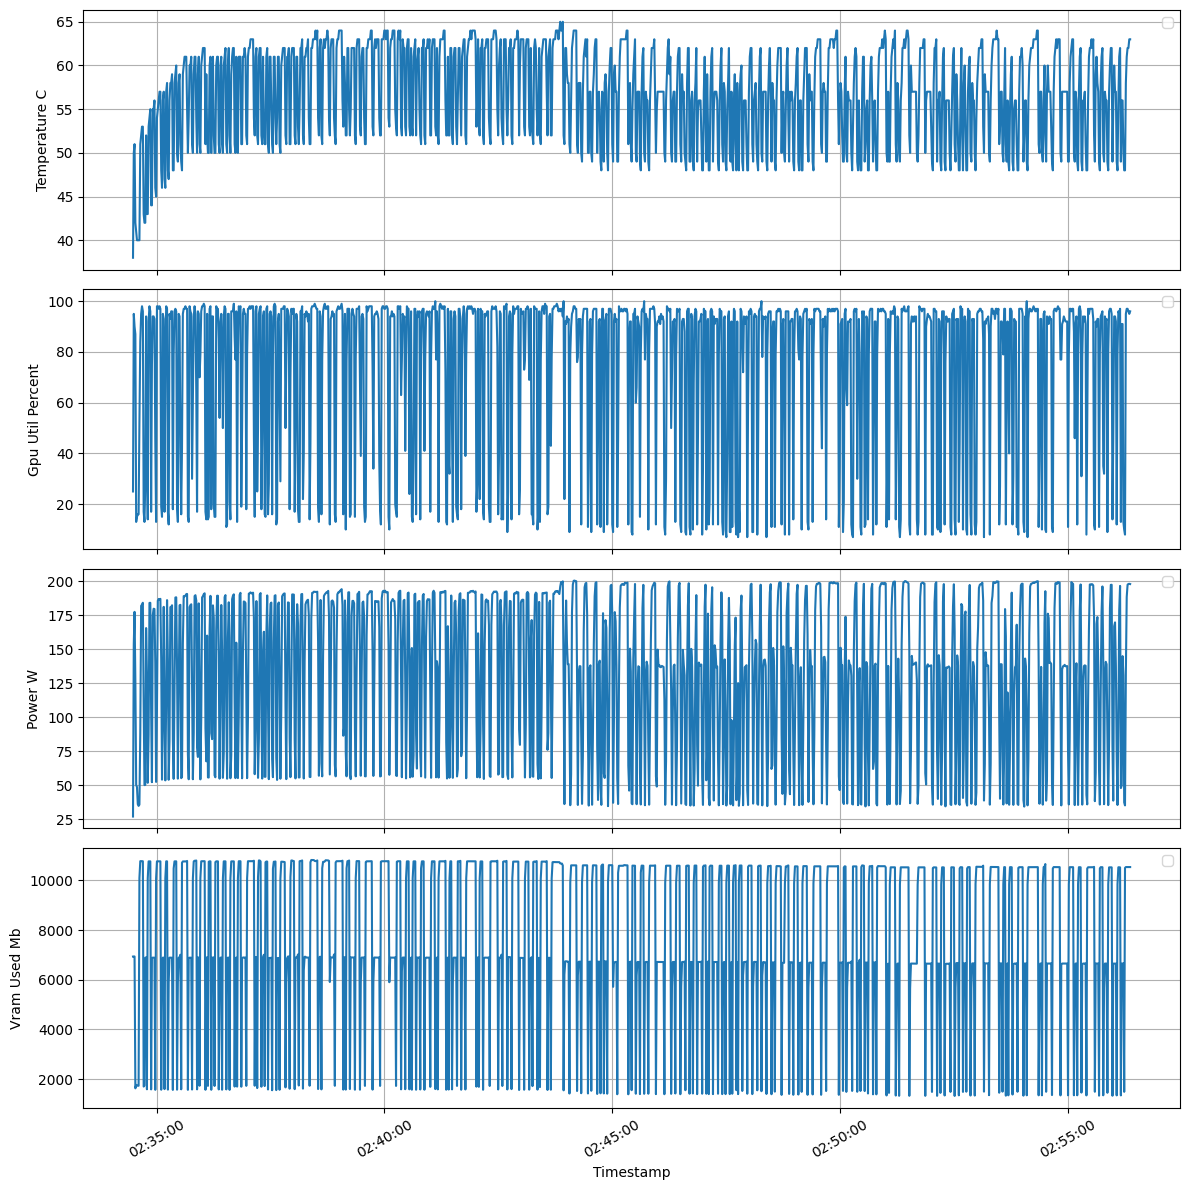

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Path to your GPU monitoring JSON file
gpu_log_path = "benchmark_results_gpu_timeseries.json"

# Load GPU monitoring data
with open(gpu_log_path, "r") as f:
    gpu_samples = json.load(f)

# Convert list of dicts into DataFrame
df = pd.DataFrame(gpu_samples)

# Parse timestamp string into datetime objects
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Optional: Sort by timestamp just in case
df = df.sort_values("timestamp")

# Select some key metrics to plot
metrics = [
    "temperature_c",
    "gpu_util_percent",
    "power_w",
    "vram_used_mb",
]

# Plot each metric for each GPU index
gpu_indices = df["gpu_index"].unique()

fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 3 * len(metrics)), sharex=True)

for i, metric in enumerate(metrics):
    ax = axs[i]

    for gpu_id in gpu_indices:
        gpu_data = df[df["gpu_index"] == gpu_id]
        ax.plot(gpu_data["timestamp"], gpu_data[metric])

    ax.set_ylabel(metric.replace("_", " ").title())
    ax.legend()
    ax.grid(True)

# Formatting the x-axis for better date-time readability
axs[-1].set_xlabel("Timestamp")
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


In [1]:
from text2sql_lib.benchmark import run_benchmark

run_benchmark(
    dataset_path="./synthetic_text_to_sql/cached_test.parquet",
    log_path="benchmark_results.jsonl",
    model_name="qwen2.5:latest",
    max_examples=50,
    gpu_monitor_interval=1.0,
    monitor_gpu=True
)

Benchmarking: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


In [3]:
from text2sql_lib.visualize import visualize_benchmark_results, visualize_benchmark_results2

# visualize_benchmark_results("benchmark_results.jsonl")

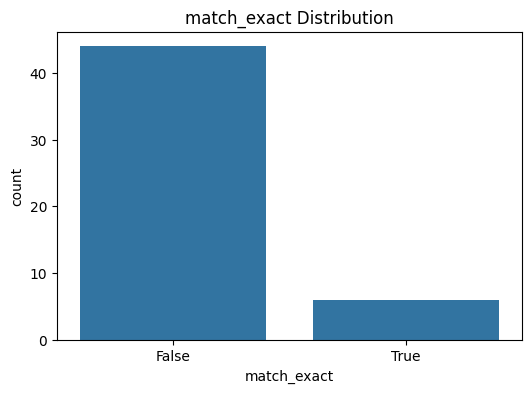

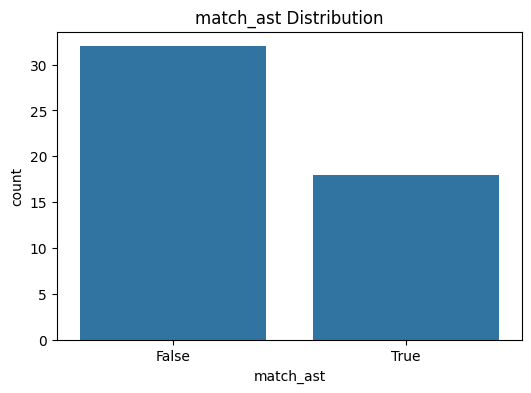

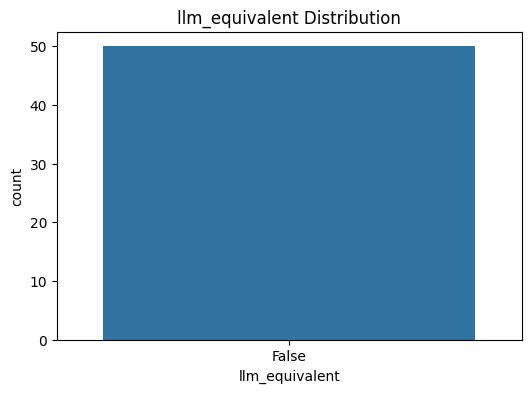

match_exact       0.12
match_ast         0.36
llm_equivalent    0.00
dtype: float64


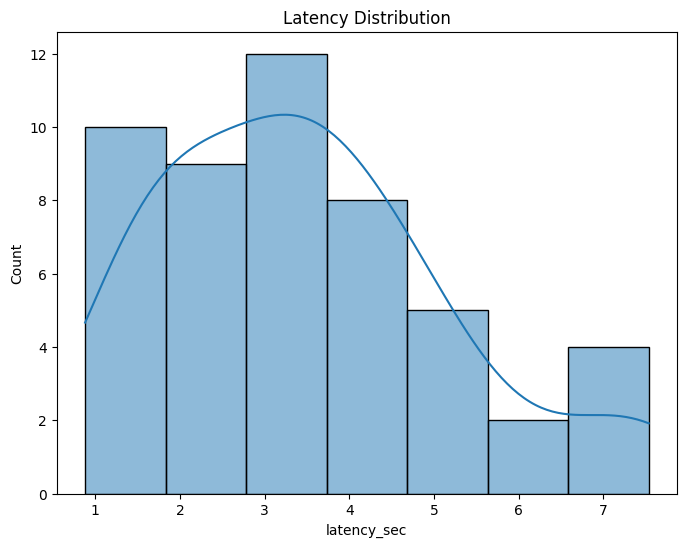

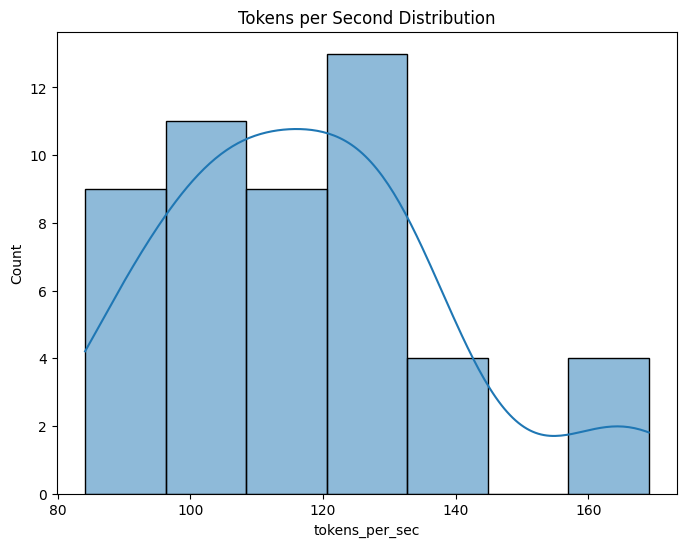

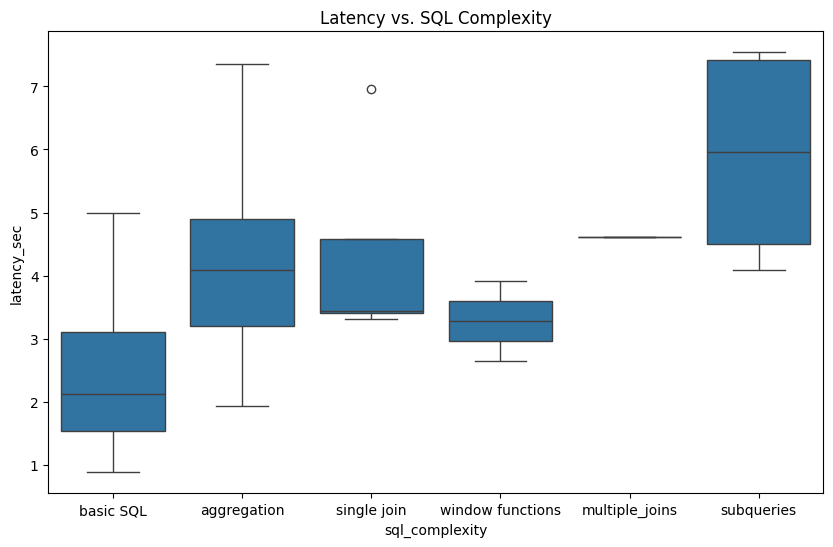

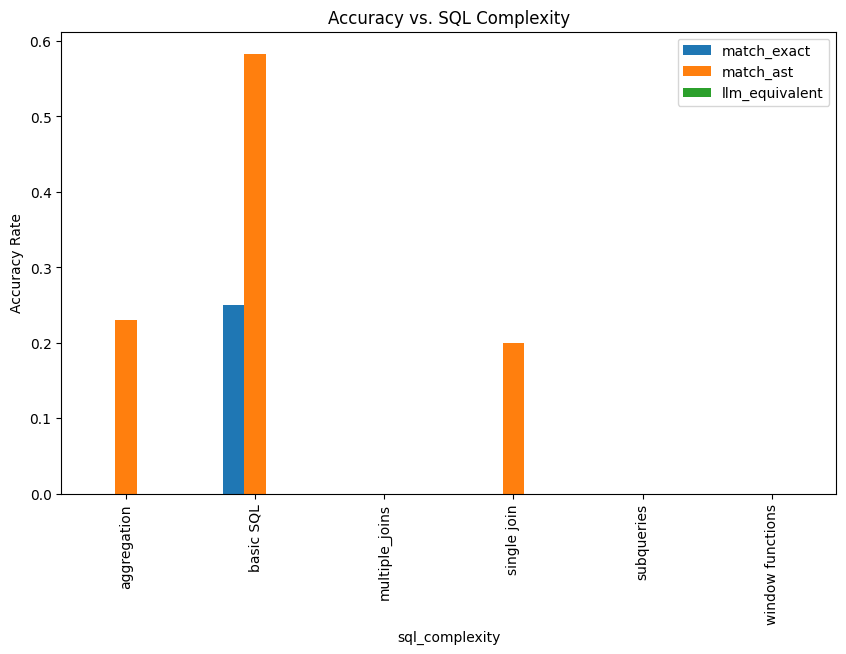

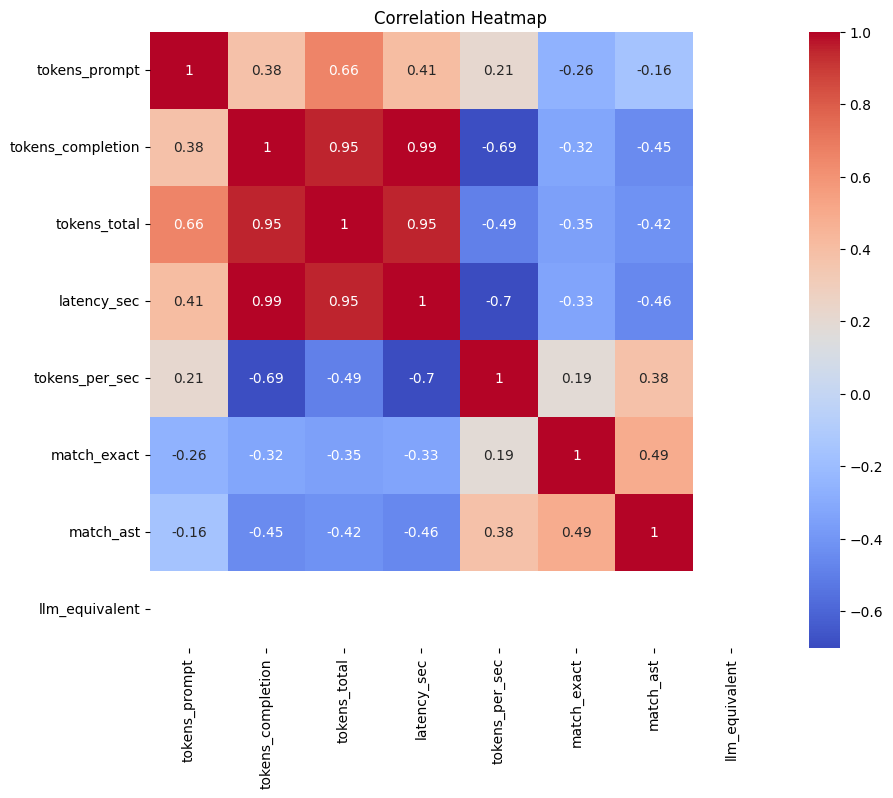

In [4]:
visualize_benchmark_results2("benchmark_results.jsonl")

In [ ]:
visualize_benchmark_results2("benchmark_results.jsonl")